In [2]:
# !pip install pytorch-lightning
# !pip install transformers
# !pip install vncorenlp

In [3]:
# from google.colab import drive
# drive.mount("/content/drive")

In [4]:
!nvidia-smi

Wed Jun 29 17:17:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:5E:00.0 Off |                  N/A |
| 29%   53C    P2    48W / 250W |   3294MiB / 11019MiB |     21%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:86:00.0 Off |                  N/A |
|  0%   

In [5]:
# !kill -9 3980682

In [6]:
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
import zipfile
from PIL import Image
import matplotlib.pyplot as plt
import re
import pytorch_lightning as pl
from torchvision import transforms as T
from sklearn.model_selection import train_test_split

train_ratio = 0.8

/home/nghiatl/anaconda3/envs/AI_DA/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
import random

# SEED_VALUE = random.randint(0,100)
SEED_VALUE = 0
# print(SEED_VALUE)
random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)
torch.cuda.manual_seed(SEED_VALUE)
np.random.seed(SEED_VALUE)

In [8]:
# %cd /content/drive/MyDrive/Colab Notebooks/Multimodal

In [9]:
# !ls
data_zip_file = './local1_folder.zip'
bin_zip_file = './mountains.zip'

csv_file2 = './OUTPUT/Comment_22.csv'
csv_file3 = './OUTPUT/Comment_23.csv'
csv_file4 = './OUTPUT/Comment_24.csv'
csv_file5 = './OUTPUT/Comment_25.csv'

csv_file = './OUTPUT/Comment.csv'

In [10]:
!nvidia-smi

Wed Jun 29 17:17:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:5E:00.0 Off |                  N/A |
|  0%   54C    P2    46W / 250W |   3294MiB / 11019MiB |     21%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:86:00.0 Off |                  N/A |
|  0%   

# Data preprocessing

## Image data

In [11]:
data_zip = zipfile.ZipFile(data_zip_file)

In [12]:
bin_zip = zipfile.ZipFile(bin_zip_file)

FileNotFoundError: [Errno 2] No such file or directory: './mountains.zip'

In [ ]:
len(bin_zip.namelist())

In [ ]:
'mountains/mountains_000581.png' in bin_zip.namelist()

In [ ]:
len(data_zip.namelist())

In [ ]:
'local1_folder-1/foody-fukunohana-hanoi-japanese-retstaurant-970-637197316556573205.jpg' in data_zip.namelist()

In [ ]:
img_path = data_zip.namelist()[1]
print(img_path)
img = Image.open(data_zip.open(img_path))
print(img)
print(np.asarray(img).shape)
plt.imshow(img)

In [ ]:
# img_path = bin_zip.namelist()[13]
img_path = 'mountains/mountains_000122.png'

print(img_path)
img = Image.open(bin_zip.open(img_path))
print(type(img))
print(img)
print(np.asarray(img).shape[2])
plt.imshow(img)

In [ ]:
# ### Scale image to [0,1]
# trans = T.ToTensor()
# trans(img).shape

## CSV data

In [ ]:
data_df1 = pd.read_csv(csv_file)
data_df2 = pd.read_csv(csv_file2)
data_df3 = pd.read_csv(csv_file3)
data_df4 = pd.read_csv(csv_file4)
data_df5 = pd.read_csv(csv_file5)

data_df1[['Comment', 'Rating']].head()

In [ ]:
data_df4.shape

In [ ]:
data_df4

In [ ]:
# def insert_bin_image(df):
#     sample_df = df.sample(frac=0.05, random_state=0)
#     df.drop(sample_df.index, inplace=True)
#     df = df.reset_index(drop=True)
#     sample_df = sample_df.reset_index(drop=True)
#     for i in range(len(sample_df)):
#         list_img = []
#         for j in range(len(sample_df.iloc[i]['image_urls'].split(','))):
#             num_ran = random.randint(0, 900)
#             num_img = '0'* (6-len(str(num_ran))) + str(num_ran)
# #             mountains/mountains_000580.png
#             list_img.append('mountains/mountains_'+ num_img + '.png')
#         sample_df.loc[i,'image_urls'] = ','.join(list_img)
    
#     df = pd.concat([df, sample_df], ignore_index = True)
    
#     return df

# data_df4 = insert_bin_image(data_df4)
# data_df4

In [ ]:
data_df = pd.concat([data_df1,data_df2,data_df3,data_df4, data_df5], ignore_index = True)

In [ ]:
data_df.shape

In [ ]:
data_df = data_df.dropna()
data_df = data_df.reset_index(drop=True)

In [ ]:
data_df.isnull().sum()

In [ ]:
## Add more data
data_df.rename(columns={"Rating":"score"}, inplace=True)
data_df.head()

In [ ]:
data_df['image_urls'][0]

In [ ]:
# ## Calculate score
# data_df['score'] = data_df.apply(lambda x: (x['Food_score_cmt']+x['Services_score_cmt']+x['Atmosphere_score_cmt']+x['Position_score_cmt']+x['Price_score_cmt'])/5, axis = 1)
data_df[(data_df['score'] >= 8) & (data_df['score'] <= 8)][['Comment','score']].sort_values(by=['score'])

In [ ]:
data_df['Comment'][8]

In [ ]:
## label data
def label_comment(x):
  if x['score'] >= 8:
    return 1
  elif (x['score'] >= 6) & (x['score'] < 8):
    return 2
  else:
    return 0
data_df['label'] = data_df.apply(label_comment, axis=1)

In [13]:
data_df = data_df[data_df['label'] != 2]

NameError: name 'data_df' is not defined

In [14]:
print(data_df['label'].value_counts())
data_df['label'].value_counts().plot(kind='barh')

NameError: name 'data_df' is not defined

In [ ]:
data_df[['Comment','label', 'score']].head()

In [15]:
data_df = data_df.drop(['Food_score_cmt','Services_score_cmt','Atmosphere_score_cmt','Position_score_cmt','Price_score_cmt'],axis=1)
data_df.head()

NameError: name 'data_df' is not defined

In [36]:
def preprocess_imgpath(df):
    img_p = []
    for path in df['image_urls'].split(","):
        img_path = 'local1_folder-1/' + path.split('/')[-1]
        if img_path in data_zip.namelist():
            img_p.append(img_path)
    if len(img_p) > 0:
        return ','.join(img_p)
    return None

In [37]:
data_df['image_urls'] = data_df.apply(preprocess_imgpath, axis=1)

In [38]:
data_df = data_df.dropna()
data_df = data_df.reset_index(drop=True)
data_df.isnull().sum()

RevId         0
UserId        0
ResId         0
Comment       0
image_urls    0
score         0
label         0
dtype: int64

1    6952
0    3023
Name: label, dtype: int64


<AxesSubplot:>

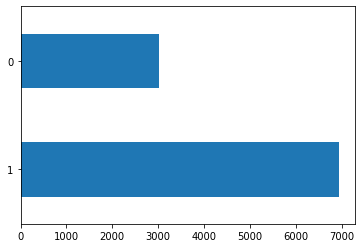

In [39]:
print(data_df['label'].value_counts())
data_df['label'].value_counts().plot(kind='barh')

In [40]:
def loaddicchar():
    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|đ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|đ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic
 
 
dicchar = loaddicchar()
 
# Đưa toàn bộ dữ liệu qua hàm này để chuẩn hóa lại
def convert_unicode(txt):
    return re.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|đ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)

In [41]:
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("./vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m') 

uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
punc_re = '[^\w'+uniChars+']'
def preprocess_text(sen):
  ##Unicode reform
  assert isinstance(sen, str), 'Not String'
  sen = convert_unicode(sen)
  ##Remove punctuation
  sen = re.sub(punc_re,' ', sen)
  ##Remove multiple space
  sen = re.sub('\s+',' ', sen)
  ##Lower
  sen = sen.lower()
  ##Segment
  seg = rdrsegmenter.tokenize(sen)
  if len(seg) == 0:
    sen = ' '
  else: 
    sen = ' '.join(seg[0])
  return sen
# vec_pre = np.vectorize(preprocess_text)
# print(vec_pre((data_df.iloc[3,3])))
data_df['preprocess_comment'] = data_df.apply(lambda x: preprocess_text(x['Comment']), axis = 1)

In [42]:
data_df.head()

,RevId,UserId,ResId,Comment,image_urls,score,label,preprocess_comment
0,3648046,8920424,965165,Đặt dồi sụn của quán vì đọc comment thấy hấp d...,local1_folder-1/foody-doi-sun-pate-shop-online...,5.8,0,đặt dồi sụn của quán vì đọc comment thấy hấp_d...
1,3695359,18558601,965165,"Dồi khá ngon, mua về còn nóng mở ra thơm phức,...",local1_folder-1/foody-doi-sun-pate-shop-online...,9.0,1,dồi khá ngon mua về còn nóng mở ra thơm_phức s...
2,3695487,13885433,965165,"Đặt xuất mỳ trộn thập cẩm, khá đầy đủ và đầy đ...",local1_folder-1/foody-doi-sun-pate-shop-online...,9.4,1,đặt xuất mỳ trộn thập_cẩm khá đầy_đủ và đầy_đặ...
3,4256913,11400976,965165,Không hiểu sao quán này được 7.9 luôn. Đặt bán...,local1_folder-1/foody-doi-sun-pate-shop-online...,4.6,0,không hiểu sao quán này được 7 9 luôn đặt bánh...
4,4246644,525112,965165,"Dồi sụn bé tẹo, giá quá cao so với các quán kh...",local1_folder-1/foody-doi-sun-pate-shop-online...,1.0,0,dồi sụn bé tẹo giá quá cao so với các quán khá...


In [43]:
data_df[data_df['preprocess_comment']==" "].shape
# data_df.drop(data_df[data_df['preprocess_comment']==" "].index, inplace = True)

(9, 8)

In [44]:
data_df = data_df.reset_index()
data_df['preprocess_comment'][4187:4191]

4187    vị_trí ở mặt đường nhưng ở cạnh quán mì cay to...
4188    thật tuyệt_cú mèo luôn mỗi cốc hoa_quả dầm ở đ...
4189    mình đã ăn_ở địa_điểm 211 chùa láng được hơn 1...
4190    nghe mọi người khen quán này dữ lém nên hôm_na...
Name: preprocess_comment, dtype: object

In [45]:
a = data_df['preprocess_comment'].str.split()
a = a.apply(lambda x: len(x))
a[a==1]

314     1
415     1
744     1
1011    1
1077    1
1543    1
1779    1
1808    1
1888    1
2302    1
2337    1
2528    1
2836    1
2873    1
2976    1
3489    1
3643    1
4328    1
4409    1
4645    1
5242    1
5564    1
5976    1
6341    1
6487    1
6748    1
7554    1
7603    1
8684    1
8881    1
9377    1
9523    1
Name: preprocess_comment, dtype: int64

In [46]:
a

0        56
1        43
2        38
3        34
4        74
       ... 
9970     42
9971     48
9972    107
9973    185
9974     17
Name: preprocess_comment, Length: 9975, dtype: int64

In [47]:
data_df['Comment'][195]

'Sữa chua mít + trà đào ngon, caramen trong sữa chua ăn cũng ok, giá vừa phải. Quán sạch sẽ, nhân viên phục vụ tốt. Sẽ quay lại.'

<AxesSubplot:>

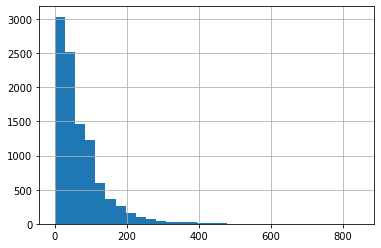

In [48]:
seq_len = [len(i.split()) for i in data_df['preprocess_comment']]

pd.Series(seq_len).hist(bins = 30)

# Load BPE, Vocab of PhoBERT and DataGen

In [49]:
from transformers import AutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [50]:
def collate_batch(batch):
  input_ids = []
  attention_masks = []
  imgs = []
  img_len = []
  labels = []
  for bt in batch:
    input_ids.append(bt[0]['input_ids'][0])
    attention_masks.append(bt[0]['attention_mask'][0])
    imgs.extend(bt[1])
    img_len.append(len(bt[1]))
    labels.append(bt[2])

  bert_tokens = torch.stack(input_ids)
  attention_masks = torch.stack(attention_masks)
  imgs_torch = torch.stack(imgs)
  labels = torch.LongTensor(labels)

  return  { 'input_ids': bert_tokens , 'attention_mask':attention_masks } , imgs_torch, img_len, labels

In [51]:
trans = T.ToTensor()
RANDOM_SEED = 0
MAX_LEN = 150


class SentimentData(Dataset):
  def __init__(self, data, transform = None):
    self.df = data.reset_index(drop=True)
    self.transform = transform
  def __len__(self):
    # print('Size',len(self.df))
    return len(self.df)  
  def __getitem__(self,idx):
    text = self.df["preprocess_comment"][idx]
    text = tokenizer(text, padding='max_length', truncation=True, max_length = MAX_LEN, return_tensors="pt")

    img_list = []
    for path in self.df['image_urls'][idx].split(","):
#       img_path = '/' + path.split('/')[-1]
        if path in data_zip.namelist():
          img = Image.open(data_zip.open(path))
          if self.transform is not None:
            img = self.transform(img)
          img_list.append(img)
#         else:
#           img = Image.open(bin_zip.open(path))
#           if self.transform is not None:
#             img = self.transform(img)
#           img_list.append(img)

    # print(text.shape)
    # text = ' '.join(text[0])
    label = self.df["label"][idx]

    return (text, img_list, label)

class SentimentDataModule(pl.LightningDataModule):
    
  def __init__(self, data, batch_size: int = 8, test_size = 0.2):
      super().__init__()
      self.test_size = test_size
      self.data = data
      self.batch_size = batch_size
      self.train_data = ''
      self.val_data = ''
      self.test_data = ''
    
#   def insert_bin_image(self, df):
#     sample_df = df.sample(frac=0.4, random_state=0)
#     df.drop(sample_df.index, inplace=True)
#     df = df.reset_index(drop=True)
#     sample_df = sample_df.reset_index(drop=True)
#     for i in range(len(sample_df)):
#         list_img = []
#         for j in range(len(sample_df.iloc[i]['image_urls'].split(','))):
#             num_img = ''
#             img = ''
#             while True:
#                 num_ran = random.randint(1, 900)
#                 num_img = '0'* (6-len(str(num_ran))) + str(num_ran)
#                 img = Image.open(bin_zip.open('mountains/mountains_'+ num_img + '.png'))
# #                 print(len(np.asarray(img).shape))
#                 if len(np.asarray(img).shape) == 3:
#                     break;
#             list_img.append('mountains/mountains_'+ num_img + '.png')
#         sample_df.loc[i,'image_urls'] = ','.join(list_img)
    
#     df = pd.concat([df,sample_df], ignore_index = True)
    
#     return df

  def prepare_data(self):
      self.train_data, self.val_data = train_test_split(self.data, test_size = self.test_size, random_state=RANDOM_SEED, stratify = self.data['label'])
#       self.train_data = self.insert_bin_image(self.train_data)
#       print(self.train_data)
      self.test_data, self.val_data = train_test_split(self.val_data,test_size = 0.5, random_state=RANDOM_SEED, stratify = self.val_data['label'])
      print(self.data['label'].value_counts())
      print(self.train_data['label'].value_counts())
      print(self.val_data['label'].value_counts())
      print(self.test_data['label'].value_counts())

  def setup(self, stage = None):
      train_transform = T.Compose([
       T.Resize([299, 299]), T.RandomHorizontalFlip(), T.RandomRotation(10),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
      ])
      val_transform = T.Compose([
        T.Resize([299, 299]), T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
      ])
      test_transform = T.Compose([
        T.Resize([299, 299]), T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
      ])
      self.train = SentimentData(self.train_data, train_transform)
      self.val = SentimentData(self.val_data, val_transform)
      self.test = SentimentData(self.test_data, test_transform)


  def train_dataloader(self):
      return DataLoader(self.train, batch_size=self.batch_size, shuffle=True, collate_fn=collate_batch)

  def val_dataloader(self):
      return DataLoader(self.val, batch_size=self.batch_size, collate_fn=collate_batch)

  def test_dataloader(self):
      return DataLoader(self.test, batch_size=self.batch_size, collate_fn=collate_batch)

  

In [52]:
# Do some Test with data
if __name__ == "__main__":
  dm = SentimentDataModule(data_df)
  dm.prepare_data()
  dm.setup()
  for step, bat in enumerate(dm.train_dataloader()):
    if step > 0: break
    print(step)
    print(bat[0]['input_ids'].shape)
    print(bat[1].shape)
    print(sum(bat[2]))
    print(len(bat[3]))

1    6952
0    3023
Name: label, dtype: int64
1    5562
0    2418
Name: label, dtype: int64
1    695
0    303
Name: label, dtype: int64
1    695
0    302
Name: label, dtype: int64
0
torch.Size([8, 150])
torch.Size([11, 3, 299, 299])
11
8


In [53]:
dm.train_data[7579:]

,index,RevId,UserId,ResId,Comment,image_urls,score,label,preprocess_comment
521,521,2659214,13591898,920318,Có đủ các loại trà mà mình thích nhất matcha l...,local1_folder-1/foody-tra-sua-mancha-tea-doan-...,8.6,1,có đủ các loại trà mà mình thích nhất matcha l...
8362,8362,2585742,227729,876305,"có code giảm giá nên đặt thử, nói chung cơm ăn...",local1_folder-1/foody-minimo-com-mi-692-636905...,9.0,1,có code giảm_giá nên đặt thử nói_chung cơm ăn ...
4635,4635,9182412,2261673,1052111,Thấy quán mới mở nên hôm nay gọi mì để thẩm xe...,local1_folder-1/foody-mi-tron-532-truong-chinh...,9.2,1,thấy quán mới mở nên hôm_nay gọi mì để thẩm xe...
519,519,2843157,14644373,295582,Thật sự thì với cái giá 20k mà được một bát ch...,local1_folder-1/foody-chao-long-ba-hong-853-63...,4.8,0,thật_sự thì với cái giá 20k mà được một bát ch...
8150,8150,1111812,1477995,122539,Mình cũng chẳng biết đây có phải địa chỉ đúng ...,local1_folder-1/foody-tra-chanh-nha-tho-286-63...,5.6,0,mình cũng chẳng biết đây có phải địa_chỉ đúng ...
...,...,...,...,...,...,...,...,...,...
2417,2417,2835833,10264997,881083,"Mì ăn ngon, hơi ít thịt nhưng giá 30k nên cũng...",local1_folder-1/foody-dung-beo-banh-mi-doner-k...,5.6,0,mì ăn ngon hơi ít thịt nhưng giá 30k nên cũng ...
5115,5115,7505366,589693,704512,Đọc kha khá review khem quán nên mặc dù hơi xa...,local1_folder-1/foody-smile-tea-coffee-908-637...,4.2,0,đọc kha_khá review khem quán nên mặc_dù hơi xa...
7718,7718,2636993,12045615,712278,"Tớ khó tính khi ăn thịt xá xíu cực kì, chỉ ưng...",local1_folder-1/foody-duc-lam-com-rang-com-dao...,9.0,1,tớ khó_tính khi ăn thịt xá_xíu cực_kì chỉ ưng ...
4479,4479,2359199,12383305,708526,Lẩu xuất sắc\nDễ tìm\nPhục vụ nhanh nhẹn\nBia ...,local1_folder-1/foody-quan-289-lau-nuong-com-v...,9.2,1,lẩu xuất_sắc dễ tìm phục_vụ nhanh_nhẹn bia ngo...


In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Computation device: cuda



# PhoBERT

In [55]:
from transformers import RobertaModel, RobertaConfig, AdamW, AutoModel
from transformers import RobertaForSequenceClassification

pretrained_config_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/config.json"
pretrained_model_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/model.bin"

In [56]:
class Bert_Lstm(nn.Module):
  def __init__(self):
    super().__init__()
    self.PhoBERT = AutoModel.from_pretrained("vinai/phobert-base")

    self.lstm = nn.LSTM(input_size=768, hidden_size=128, num_layers= 1, batch_first=True)
  
  def forward(self, texts):
    bert_out = self.PhoBERT(texts['input_ids'],token_type_ids=None, attention_mask = texts['attention_mask'])
    bert_out = bert_out['last_hidden_state']
    out, _ = self.lstm(bert_out)
    feature_extract = out[:,-1,:].contiguous()

    return feature_extract

In [57]:
# # This time, the output's 2nd dimension is 3, indicating that there were 3 outputs given by the LSTM. 
# # This corresponds to the length of our input sequence. 
# # For the use cases where we'll need an output at every time step (many-to-many), such as Text Generation, the output of each time step can be extracted directly from the 2nd dimension and fed into a fully connected layer. 
# # For text classification tasks (many-to-one), such as Sentiment Analysis, the last output can be taken to be fed into a classifier.

# pho_test = Bert_Lstm()
# pho_test
# # oooo = pho_test('iiii')
# for name, child in pho_test.named_children():
#   print(name)

# InceptionV3

In [58]:
from torchvision.models import inception_v3

In [59]:
# class Inception(nn.Module):
#   def __init__(self):
#     super(Inception,self).__init__()
#     self.incept = inception_v3(pretrained = True,progress = True,aux_logits= False,transform_input = True)
#     self.incept_sequen = nn.Sequential(*list(self.incept.children())[:-3])
#     self.avgpool = nn.AdaptiveAvgPool2d((1,1))
#     self.drop = nn.Dropout(p=0.4)
#     self.flat = nn.Linear(2048, 128)

#   def process(self, feature, len_img_list):
#     max_fea = torch.zeros(len(len_img_list), feature.shape[-1]).to(device)
#     start = 0
#     for idx, num in enumerate(len_img_list):
#       max_fea[idx] = feature[start:start+num].max(0)[0]
#       start += num

#     return max_fea
  

#   def forward(self, image, len_img_list):
#     feature = self.incept_sequen(image)
#     feature = self.avgpool(feature)
#     feature = self.drop(feature)
#     feature = feature.reshape(-1, 2048)
# #     feature = self.drop(feature)
#     # out = self.avgpool(feature)
#     # print(out.shape)
#     # out = out.contiguous().view(-1, 2048)
#     out = self.process(feature, len_img_list)
#     img_fea = self.flat(out)

#     return img_fea


In [60]:
# img_fea = torch.rand(4,128).to(device)
# img_fea.shape
# text_fea = torch.rand(2,128).to(device)
# len_img_list=[2,2]

In [61]:
# def attention(image_fea, text_fea, len_img_list):
#     m = nn.Softmax(dim=0)
#     scale = 1.0/np.sqrt(128)
# #     context_vector = torch.mul(text_fea, m(torch.matmul(text_fea, img_fea.permute(1,0))))
#     context_vector = torch.zeros(len(len_img_list), 128).to(device)
#     start_term = 0
#     for i in range(len(len_img_list)):
#         context_vector[i] = torch.mul(text_fea[i], m(torch.matmul(image_fea[start_term: start_term + len_img_list[i]], text_fea[i].contiguous().view(128,-1))*scale)).sum(dim=0)
#         start_term += len_img_list[i]
#     return context_vector

In [62]:
# m = nn.Softmax(dim=0)
# scale = 1.0/np.sqrt(128)
# m(torch.matmul(img_fea[0: 2], text_fea[0].contiguous().view(128,-1))*scale)

In [63]:
# print(img_fea[0: 2].shape)
# img_fea[0: 2]

In [64]:
# torch.mul(img_fea[0:2], m(torch.matmul(img_fea[0: 2], text_fea[0].contiguous().view(128,-1))*scale))

In [65]:
# torch.matmul(img_fea[0: 2], text_fea[0].contiguous().view(128,-1))

In [66]:
# context = attention(img_fea, text_fea, len_img_list)
# context

In [67]:
# context.shape

In [68]:
class Inception(nn.Module):
  def __init__(self):
    super(Inception,self).__init__()
    self.incept = inception_v3(pretrained = True,progress = True,aux_logits= False,transform_input = True)
    self.incept_sequen = nn.Sequential(*list(self.incept.children())[:-3])
    self.avgpool = nn.AdaptiveMaxPool2d((1,1))
    self.drop = nn.Dropout(p=0.4)
#     self.flat = nn.Linear(2048, 128)
    self.ffn = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
#             nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(128, 2),
        )
    self.atten = nn.Linear(128, 1, bias=False)
#     self.cl = nn.Linear(128,2)
  def attention(self, image_fea, atten_coef ,len_img_list):
    m = nn.Softmax(dim=0)
    scale = 1.0/np.sqrt(128)
#     context_vector = torch.mul(text_fea, m(torch.matmul(text_fea, img_fea.permute(1,0))))
    context_vector = torch.zeros(len(len_img_list), 128).to(device)
    start_term = 0
    for i in range(len(len_img_list)):
        context_vector[i] = torch.mul(image_fea[start_term: start_term + len_img_list[i]], m(atten_coef[start_term: start_term + len_img_list[i]]*scale)).sum(dim=0)
        start_term += len_img_list[i]
    return context_vector
  
  def forward(self, image, len_img_list):
    image = image.to(device)
    
    feature = self.incept_sequen(image)
    feature = self.avgpool(feature)
    feature = self.drop(feature)

    img_fea = feature.reshape(-1, 2048)
    out = self.ffn(img_fea)
    atten_coef = self.atten(out)
    
    context = self.attention(out, atten_coef, len_img_list)
#     logits = self.cl(context)
    
    return context


In [68]:
class Inception(nn.Module):
  def __init__(self):
    super(Inception,self).__init__()
    self.incept = inception_v3(pretrained = True,progress = True,aux_logits= False,transform_input = True)
    self.incept_sequen = nn.Sequential(*list(self.incept.children())[:-3])
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.drop = nn.Dropout(p=0.4)
#     self.flat = nn.Linear(2048, 128)
    self.ffn = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
#             nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(128, 2),
        )
  
  def forward(self, image, len_img_list):
    feature = self.incept_sequen(image)
    feature = self.avgpool(feature)
    feature = self.drop(feature)

    img_fea = feature.reshape(-1, 2048)
    out = self.ffn(img_fea)

    
    return out


In [69]:
# inc = inception_v3(pretrained = True,progress = True,aux_logits= False,transform_input = False)
# inc

In [70]:
# incept_sequen = nn.Sequential(*list(inc.children())[:-3])
# incept_sequen

In [71]:
# from tensorflow.keras.applications.inception_v3 import InceptionV3
# from tensorflow.keras import layers
# from tensorflow.keras import models
# from tensorflow.keras.models import Model

# basemodel = InceptionV3(weights='imagenet', include_top=False, input_tensor=layers.Input(shape=(299, 299, 3)))
# x = basemodel.output
# # t = layers.AveragePooling2D(pool_size=(8, 8), name='AVG_Pooling')(x)
# model_cnn = Model(basemodel.input, x)

# basemodel.summary()

In [72]:
# ou = model_cnn(np.random.rand(1,299,299,3))

In [73]:
# ou.shape

# Multimodal (no pytorch-lightning)

In [74]:
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter('runs/mrtrongmodel')

class LRScheduler():
    def __init__(
        self, optimizer, patience=1, min_lr=1e-6, factor=0.1
    ):
        self.optimizer = optimizer
        self.patience = patience
        self.min_lr = min_lr
        self.factor = factor
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
                self.optimizer,
                mode='max',
                patience=self.patience,
                factor=self.factor,
                min_lr=self.min_lr,
                verbose=True
            )
    def __call__(self, val_loss):
        self.lr_scheduler.step(val_loss)

class EarlyStopping():
    def __init__(self, patience=8, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [75]:
class Concatmodal(nn.Module):
  def __init__(self):
    super(Concatmodal,self).__init__()
    # self.loss_module = nn.CrossEntropyLoss()
    self.BERT = Bert_Lstm()
    self.incept = Inception()
    self.dense = nn.Linear(256,256)
    self.cl = nn.Linear(256,2)
    # self.bpe_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/bpe.codes"
    # self.vocab_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/dict.txt"
    
#   def attention(self, image_fea, text_fea, len_img_list):
#     m = nn.Softmax(dim=0)
#     scale = 1.0/np.sqrt(128)
# #     context_vector = torch.mul(text_fea, m(torch.matmul(text_fea, img_fea.permute(1,0))))
#     context_vector = torch.zeros(len(len_img_list), 128).to(device)
#     start_term = 0
#     for i in range(len(len_img_list)):
#         context_vector[i] = torch.mul(image_fea[start_term: start_term + len_img_list[i]], m(torch.matmul(image_fea[start_term: start_term + len_img_list[i]], text_fea[i].contiguous().view(128,-1))*scale)).sum(dim=0)
#         start_term += len_img_list[i]
#     return context_vector
        
  def forward(self, image, inputs, len_img_list, labels=None):
    for key in inputs:
        inputs[key] = inputs[key].to(device)
    image = image.to(device)

    fea1 = self.BERT(inputs)
    fea2 = self.incept(image, len_img_list)
    
#     context_vec = self.attention(fea2, fea1,  len_img_list)
    cat = torch.cat((fea1, fea2), 1)
    out = self.cl(cat)

    return out


In [76]:
def fit(model, dm, criterion, optimizer, epoch):
  running_loss = 0.0
  train_running_loss = 0.0
  # running_correct = 0
  reporting_step = 100
  train_preds = np.array([])
  train_labels = np.array([])

  counter = 0
  # total = 0
  soft_m = nn.Softmax(dim=-1)

  model.train()

  for i, (texts, images, len_img_list, labels) in enumerate(dm.train_dataloader()):
      counter += 1
      labels = labels.to(device)
      optimizer.zero_grad()

      outputs = model(images, texts, len_img_list)
      loss = criterion(outputs, labels)
      output_scores = soft_m(outputs)
      predictions = torch.argmax(output_scores, dim=-1)

      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      train_running_loss += loss.item()
        
      predictions = predictions.cpu().numpy()
      labels = labels.cpu().numpy()
      # _, preds = torch.max(outputs.data, 1)
      train_preds = np.concatenate((train_preds, predictions), axis=0)
      train_labels = np.concatenate((train_labels, labels), axis=0)

      if i % reporting_step == reporting_step-1:
            print(f"Epoch {epoch} Step {i} ave_loss {running_loss/reporting_step:0.4f}")
            running_loss = 0.0
            
  train_loss = train_running_loss / counter
  reports = classification_report(train_labels, train_preds, output_dict=True)
  print(confusion_matrix(train_labels, train_preds))
  train_ac = classification_report(train_labels, train_preds, output_dict=True)['macro avg']['f1-score']
    
#   writer.add_scalar("Loss/train", train_loss, epoch)
#   writer.add_scalar("macro-f1/train", reports['macro avg']['f1-score'], epoch)
#   writer.add_scalar("Acc/train", train_ac, epoch)


  return train_loss, train_ac

In [77]:
def validation(model, dm, criterion):
  model.eval()
  val_running_loss = 0.0
  val_preds = np.array([])
  val_labels = np.array([])

  soft_m = nn.Softmax(dim=-1)

  counter = 0

  with torch.no_grad():
    for i, (texts, images, len_img_list, labels) in enumerate(dm.val_dataloader()):
        counter += 1
        labels = labels.to(device)

        outputs = model(images, texts, len_img_list)

        loss = criterion(outputs, labels)
        output_scores = soft_m(outputs)
        predictions = torch.argmax(output_scores, dim=-1)

        predictions = predictions.cpu().numpy()
        labels = labels.cpu().numpy()
        
        val_running_loss += loss.item()
        val_preds = np.concatenate((val_preds, predictions), axis=0)
        val_labels = np.concatenate((val_labels, labels), axis=0)
    

  val_loss = val_running_loss / counter
  print(classification_report(val_labels, val_preds))
  print(confusion_matrix(val_labels, val_preds))
#   val_ac = accuracy_score(val_labels, val_preds)
  val_ac = classification_report(val_labels, val_preds, output_dict=True)['macro avg']['f1-score']


#   writer.add_scalar("Loss/val", val_loss, epoch)
#   writer.add_scalar("Acc/val", val_ac, epoch)
#   writer.add_scalar("macro-f1/val", reports['macro avg']['f1-score'], epoch)
  
  return val_loss, val_ac


In [78]:

def testing(model, dm):
  model.eval()
  test_running_loss = 0.0
  counter = 0
  test_preds = torch.tensor([], device=device)
  test_labels = torch.tensor([], device = device)

  soft_m = nn.Softmax(dim=-1)


  with torch.no_grad():
    for i, (texts, images, inputs, labels) in enumerate(dm.test_dataloader()):
        counter += 1
        labels = labels.to(device)

        outputs = model(images, texts, inputs)

        output_scores = soft_m(outputs)
        predictions = torch.argmax(output_scores, dim=-1)

        test_preds = torch.cat((test_preds, predictions), dim=0)
        test_labels = torch.cat((test_labels, labels), dim=0)

        # loss = criterion(outputs, labels)
        # test_running_loss += loss.item()
    
  test_preds = test_preds.cpu().numpy()
  test_labels = test_labels.cpu().numpy()
       
  print('test', classification_report(test_labels, test_preds))
  print('test_ac', accuracy_score(test_labels, test_preds))
  print('Confusion', confusion_matrix(test_labels, test_preds))
  print('Macro_f1', classification_report(test_labels, test_preds, output_dict=True)['macro avg']['f1-score'])
  
  # test_loss = test_running_loss / counter



In [79]:
# (t, i ,l) = next(iter(dm.train_dataloader()))
# mo = Concatmodal()
# ou = mo(i, t)
# print(ou)
# sf = nn.Softmax(dim=-1)
# ou = sf(ou)
# print(ou)
# ou = torch.argmax(ou, dim=-1)
# print(ou)

In [80]:
# testing(mo, dm)

In [81]:
def save_checkpoint(state, filename='my_checkpoint_attention_seed_84.pth.tar'):
    print('Saving....'+ filename)
    torch.save(state, filename)

In [82]:
def save_checkpoint1(state, filename='my_checkpoint_attention_seed_84_f1.pth.tar'):
    print('Saving....'+ filename)
    torch.save(state, filename)

In [83]:
%ls

archive.zip
Attetion-Multimodal-Bin2.ipynb
Attetion-Multimodal-Bin2-Moredata-Copy1.ipynb
Attetion-Multimodal-Bin2-Moredata.ipynb
Attetion-Multimodal-Bin.ipynb
Attetion-Multimodal.ipynb
Attetion-Multimodal-LateFusion-Copy1.ipynb
Attetion-Multimodal-LateFusion.ipynb
Attetion-Multimodal-seed25-1e-3-Copy1.ipynb
Attetion-Multimodal-seed25-1e-3.ipynb
Attetion-Multimodal-seed7.ipynb
Attetion-Multimodal-Soccer.ipynb
CNN.ipynb
Inception-Attetion-Copy1.ipynb
Inception-Attetion-Copy2.ipynb
Inception-Attetion.ipynb
Inception.ipynb
Inception-VotingMultimodal.ipynb
local1_folder_temp.zip
local1_folder.zip
mountains.zip
Multimodal_newmodel.ipynb
Multimodal_newmodel-weight.ipynb
my_checkpoint_attention_seed_84_bin_img.pth.tar
my_checkpoint_attention_seed_84_f1_bin_img.pth.tar
my_checkpoint_attention_seed_84_f1.pth.tar
my_checkpoint_attention_seed_84.pth.tar
my_checkpoint_incept_attention_seed_84_1e-3_data_weight.pth.tar
my_checkpoint_incept_attention_seed_84_1e-3_drop02.pth.tar
my_checkpoint_incept_at

In [84]:
# model = Concatmodal()
# total_params = sum(p.numel() for p in model.parameters())
# print(f"{total_params:,} total parameters.")
# total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(f"{total_trainable_params:,} training parameters.")

In [85]:
def freeze(model):  
  for param in model.BERT.PhoBERT.parameters():
    param.requires_grad = False
  for param in model.incept.incept.parameters():
    param.requires_grad = False
  return model

def unfreeze(model):  
  for param in model.BERT.PhoBERT.parameters():
    param.requires_grad = True
  for param in model.incept.incept.parameters():
    param.requires_grad = True
    # print(param)
  return model

In [86]:
# total_params = sum(p.numel() for p in model.parameters())
# print(f"{total_params:,} total parameters.")
# total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(f"{total_trainable_params:,} training parameters.")

In [87]:
# import gc
# del model
# gc.collect()

In [88]:
model = Concatmodal()
model = freeze(model)

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [89]:
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

160,473,802 total parameters.
1,640,962 training parameters.


In [90]:
model

Concatmodal(
  (BERT): Bert_Lstm(
    (PhoBERT): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(64001, 768, padding_idx=1)
        (position_embeddings): Embedding(258, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): Linear(in_features=768, out_featur

In [91]:
from sklearn.utils.class_weight import compute_class_weight

class_weights=compute_class_weight(class_weight='balanced', classes=np.unique(dm.train_data['label']), y=dm.train_data['label'])
class_weights=torch.tensor(class_weights,dtype=torch.float).to(device)

In [92]:
!nvidia-smi

Fri Apr 29 20:33:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:5E:00.0 Off |                  N/A |
|  0%   50C    P2   129W / 250W |   4483MiB / 11019MiB |     30%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:86:00.0 Off |                  N/A |
|  0%   

In [93]:
from torch.optim import lr_scheduler

train_loss_list=[]
epoch_list=[]
val_loss_list=[]
val_f1_list=[]
train_f1_list=[]


#define model
model.to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
# define hyper
# grouped_params = [
#     {"params": [p for n, p in roberta_params], "lr": 1e-5},
#     # {"params": [p for n, p in classifier_params], "lr": 3e-3}
# ]
# optimizer = torch.optim.Adam([
#         {'params': model.BERT.lstm.parameters()},  
#         {'params': model.incept.flat.parameters()}, 
#         {'params': model.incept.avgpool.parameters()},  
#         {'params': model.dense.parameters()},       
#         {'params': model.cl.parameters()},       
#         {'params': model.BERT.PhoBERT.parameters(), 'lr': 1e-5},
#         {'params': model.incept.incept.parameters(), 'lr': 1e-5}
#     ], lr=1e-3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#training
# def training(model, optimizer):
# define hyper
criterion = nn.CrossEntropyLoss(weight=class_weights)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
epochs = 20
lr_scheduler = LRScheduler(optimizer)
early_stopping = EarlyStopping()
min_loss = np.Inf
max_f1 = 0

for epoch in range(epochs):
  print(f"Epoch {epoch} of {epochs}")
  train_epoch_loss, train_ac = fit(
        model, dm, criterion, optimizer, epoch
    )
  val_epoch_loss, val_epoch_ac = validation(
        model, dm, criterion
    )

  lr_scheduler(val_epoch_ac)

  print('Train acc', train_ac)
  print(f"Train Loss: {train_epoch_loss:.4f}")
  print(f'Val Loss: {val_epoch_loss:.4f}')
  print(f'Val Acc: {val_epoch_ac:.4f}')
    
  train_loss_list.append(train_epoch_loss)
  train_f1_list.append(train_ac)
  val_loss_list.append(val_epoch_loss)
  val_f1_list.append(val_epoch_ac)
  epoch_list.append(epoch)
    
  checkpoint ={'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch, 'loss':val_epoch_loss }
  if (min_loss >= val_epoch_loss):
      print('Better ver saved')
      min_loss = val_epoch_loss
      save_checkpoint(checkpoint)
        
  if (val_epoch_ac >= max_f1):
      checkpoint ={'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch, 'loss': val_epoch_loss, "f1": val_epoch_ac}
      print('Better ver saved')
      max_f1 = val_epoch_ac
      save_checkpoint1(checkpoint)
    
  early_stopping(val_epoch_loss)
  if early_stopping.early_stop:
      break

testing(model, dm)

160,473,802 total parameters.
1,640,962 training parameters.
Epoch 0 of 20
Epoch 0 Step 99 ave_loss 0.6339
Epoch 0 Step 199 ave_loss 0.5528
Epoch 0 Step 299 ave_loss 0.3966
Epoch 0 Step 399 ave_loss 0.3862
Epoch 0 Step 499 ave_loss 0.5016
Epoch 0 Step 599 ave_loss 0.3857
Epoch 0 Step 699 ave_loss 0.3917
Epoch 0 Step 799 ave_loss 0.3542
Epoch 0 Step 899 ave_loss 0.3671
[[1835  583]
 [ 855 4707]]
              precision    recall  f1-score   support

         0.0       0.86      0.78      0.82       303
         1.0       0.91      0.95      0.93       695

    accuracy                           0.89       998
   macro avg       0.88      0.86      0.87       998
weighted avg       0.89      0.89      0.89       998

[[236  67]
 [ 38 657]]
Train acc 0.7929853390141899
Train Loss: 0.4356
Val Loss: 0.3424
Val Acc: 0.8720
Better ver saved
Saving....my_checkpoint_attention_seed_84.pth.tar
Better ver saved
Saving....my_checkpoint_attention_seed_84_f1.pth.tar
Epoch 1 of 20
Epoch 1 Step 99 ave_

[[2178  240]
 [ 169 5393]]
              precision    recall  f1-score   support

         0.0       0.92      0.87      0.90       303
         1.0       0.95      0.97      0.96       695

    accuracy                           0.94       998
   macro avg       0.93      0.92      0.93       998
weighted avg       0.94      0.94      0.94       998

[[264  39]
 [ 22 673]]
Epoch 00010: reducing learning rate of group 0 to 1.0000e-05.
Train acc 0.9388158125980952
Train Loss: 0.1768
Val Loss: 0.2365
Val Acc: 0.9265
INFO: Early stopping counter 3 of 8
Epoch 10 of 20
Epoch 10 Step 99 ave_loss 0.2111
Epoch 10 Step 199 ave_loss 0.1590
Epoch 10 Step 299 ave_loss 0.1936
Epoch 10 Step 399 ave_loss 0.1634
Epoch 10 Step 499 ave_loss 0.1703
Epoch 10 Step 599 ave_loss 0.1698
Epoch 10 Step 699 ave_loss 0.1762
Epoch 10 Step 799 ave_loss 0.1544
Epoch 10 Step 899 ave_loss 0.1523
[[2187  231]
 [ 168 5394]]
              precision    recall  f1-score   support

         0.0       0.93      0.87      0.9

In [1]:
def show_graph(train_accu, eval_accu, epoch_list, type='F1'):
    plt.plot(epoch_list,train_accu ,'-o')
    plt.plot(epoch_list,eval_accu,'-o')
    plt.xlabel('epoch')
    plt.ylabel(type)
    plt.legend(['Train','Valid'])
    plt.title('Train vs Valid '+type)

    plt.show()

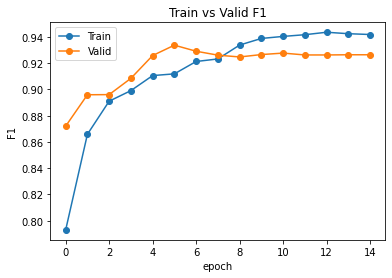

In [96]:
# freeze inception seed 66 
show_graph(train_f1_list, val_f1_list, epoch_list)

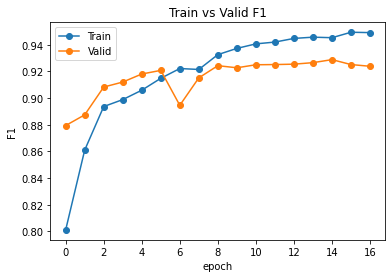

In [97]:
# freeze inception seed 84 
show_graph(train_f1_list, val_f1_list, epoch_list)

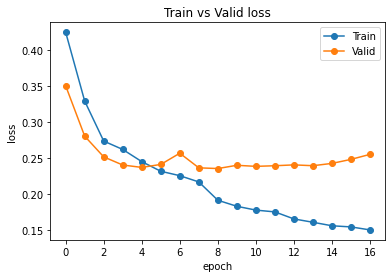

In [98]:
# freeze inception seed 84 
show_graph(train_loss_list, val_loss_list, epoch_list, 'loss')

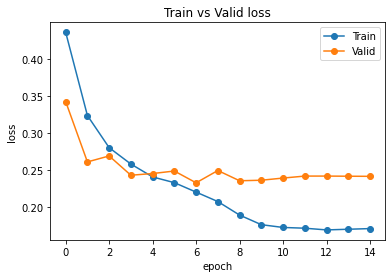

In [97]:
# freeze inception seed 66 
show_graph(train_loss_list, val_loss_list, epoch_list, 'loss')

In [98]:
import gc
del model 
gc.collect()

6992

In [99]:
torch.cuda.empty_cache()

In [100]:
PATH = "my_checkpoint_attention_seed_84.pth.tar"
checkpoint = torch.load(PATH, map_location=device)
model = Concatmodal()
model.load_state_dict(checkpoint['state_dict'])
model.to(device)
print(checkpoint['epoch'])

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


6


In [106]:
#f1
testing(model, dm)

test               precision    recall  f1-score   support

         0.0       0.93      0.89      0.91       302
         1.0       0.95      0.97      0.96       695

    accuracy                           0.95       997
   macro avg       0.94      0.93      0.94       997
weighted avg       0.95      0.95      0.95       997

test_ac 0.9478435305917753
Confusion [[269  33]
 [ 19 676]]
Macro_f1 0.937413684871312


In [102]:
#valloss 
testing(model, dm)

test               precision    recall  f1-score   support

         0.0       0.94      0.91      0.92       302
         1.0       0.96      0.97      0.97       695

    accuracy                           0.95       997
   macro avg       0.95      0.94      0.94       997
weighted avg       0.95      0.95      0.95       997

test_ac 0.9538615847542627
Confusion [[274  28]
 [ 18 677]]
Macro_f1 0.9448508898508898


In [75]:
optimizer = torch.optim.Adam([
        {'params': model.BERT.lstm.parameters()},  
        {'params': model.incept.flat.parameters()}, 
        {'params': model.incept.avgpool.parameters()},  
        {'params': model.dense.parameters()},       
        {'params': model.cl.parameters()},       
        {'params': model.BERT.PhoBERT.parameters(), 'lr': 1e-5},
        {'params': model.incept.incept.parameters(), 'lr': 1e-5}
    ], lr=1e-3)
optimizer.load_state_dict(checkpoint['optimizer'])

In [ ]:
import cv2
def plot(model):
  model.eval()
  test_preds = torch.tensor([], device=device)
  test_labels = torch.tensor([], device = device)
  test_text = []
  test_img = []

  soft_m = nn.Softmax(dim=-1)
  with torch.no_grad():
    for i, (texts, images, labels) in enumerate(dm.test_dataloader()):
        labels = labels.to(device)

        outputs = model(images, texts)

        output_scores = soft_m(outputs)
        predictions = torch.argmax(output_scores, dim=-1)

        test_preds = torch.cat((test_preds, predictions), dim=0)
        test_labels = torch.cat((test_labels, labels), dim=0)
        for t in texts:
          test_text.append(t) 
        for i in images:
          test_img.append(i) 

    
    test_preds = test_preds.cpu().numpy()
    test_labels = test_labels.cpu().numpy()
  i = 1
  plt.figure(figsize=(40,40))
  print(len(test_labels))
  for image, actual_label, label, text in zip(test_img, test_labels, test_preds, test_text):

      if (actual_label == label):

        plt.subplot(4,4,i)
        i+=1
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = T.ToPILImage()(image).convert("RGB")
        plt.imshow(image)
        plt.axis('off')
        plt.title("Text: {}...\n Actual: {}\n Predicted: {}".format(text[:30], actual_label, label))
        # plt.xlabel(text)
      else:
        pass
      if (i==17):
        break;
  plt.savefig('res_freeze_af20epoch.png', bbox_inches='tight')
  plt.show()
  

plot(model)


In [98]:
torch.cuda.empty_cache()

In [99]:
!nvidia-smi

Sun Mar 20 23:13:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:5E:00.0 Off |                  N/A |
|  0%   35C    P2    43W / 250W |  11004MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:86:00.0 Off |                  N/A |
|  0%   

# Multimodal

In [ ]:
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score

class Multimodal(pl.LightningModule):
  def __init__(self, lr_multi, lr_classifier):
    super(Multimodal,self).__init__()
    self.loss_module = nn.CrossEntropyLoss()
    self.BERT = Bert_Lstm()
    self.incept = Inception()
    self.dense = nn.Linear(256,256)
    self.cl = nn.Linear(256,3)
    self.bpe_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/bpe.codes"
    self.vocab_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/dict.txt"
    self.lr_multi = lr_multi
    self.lr_classifier = lr_classifier

    # self.model = self._build_model()
    # self.trainer_params = self._get_trainer_params()

  def forward(self, image, texts, labels=None):
    inputs = tokenize_data(texts, self.vocab_path, self.bpe_path)
    # b_labels = None
    # b_labels = labels.to(self.device)

    for key in inputs:
        inputs[key] = inputs[key].to(self.device)
    image = image.to(self.device)

    fea1 = self.BERT(inputs)
    fea2 = self.incept(image)
    cat = torch.cat((fea1, fea2), 1)
    out = self.cl(cat)

    return out
  
  def configure_optimizers(self):
    roberta_params = self.BERT.parameters()
    inception_params = self.incept.parameters()
    dense_params = self.dense.parameters()
    classifier_params = self.cl.parameters()

    # for n,p in classifier_params:
    #   print(n,p)

    # grouped_params = [
    #     {"params": roberta_params, "lr": self.lr_multi},
    #     {"params": inception_params, "lr": self.lr_multi},
    #     {"params": dense_params, "lr": self.lr_multi},
    #     {"params": classifier_params, "lr": self.lr_classifier}
    # ]
    # optimizer = torch.optim.AdamW(
    #     grouped_params
    # )
    optimizer = torch.optim.AdamW(
              self.parameters(), 
              lr = 0.001
          )

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.98)
  


  def training_step(self, batch, batch_idx):
    texts, images, labels = batch
    preds = self(images, texts, labels)
    labels = labels.to(self.device)

    loss = self.loss_module(preds, labels)

    return loss
  
  def validation_step(self, batch, batch_idx):
    texts, images, labels = batch
    logits = self(images, texts, labels)

    loss = self.loss_module(logits, labels)
    output_scores = torch.softmax(logits, dim=-1)

    return loss, output_scores, labels

  def validation_epoch_end(self, validation_step_outputs):
    val_preds = torch.tensor([], device=self.device)
    val_scores = torch.tensor([], device=self.device)
    val_labels = torch.tensor([], device=self.device)
    val_loss = 0
    total_item = 0

    for idx, item in enumerate(validation_step_outputs):
        loss, output_scores, labels = item

        predictions = torch.argmax(output_scores, dim=-1)
        val_preds = torch.cat((val_preds, predictions), dim=0)
        val_scores = torch.cat((val_scores, output_scores[:, 1]), dim=0)
        val_labels = torch.cat((val_labels, labels), dim=0)

        val_loss += loss
        total_item += 1

    # print("VAL PREDS", val_preds.shape)
    # print("VAL SCORES", val_scores.shape)
    # print("VAL LABELS", val_labels.shape)
    val_preds = val_preds.cpu().numpy()
    val_scores = val_scores.cpu().numpy()
    val_labels = val_labels.cpu().numpy()

    # reports = classification_report(val_labels, val_preds, output_dict=True)
    print("VAL PREDS", val_preds)
    print("VAL LABELS", val_labels)
    print("VAL SCORES", val_scores)
    # try:
    #     auc = roc_auc_score(val_labels, val_scores)
    # except Exception as e:
    #     print(e)
    #     print("Cannot calculate AUC. Default to 0")
    #     auc = 0
    accuracy = accuracy_score(val_labels, val_preds)

    print(classification_report(val_labels, val_preds))

    self.log("loss/val", val_loss)
    # self.log("auc/val", auc)
    self.log("accuracy/val", accuracy)
    # self.log("precision/val", reports["weighted avg"]["precision"])
    # self.log("recall/val", reports["weighted avg"]["recall"])
    # self.log("f1/val", reports["weighted avg"]["f1-score"])




In [ ]:
# trainer = pl.Trainer(
#     fast_dev_run=True,
# )
# multi = Multimodal(lr_multi=1e-5, lr_classifier=3e-3)
# dm = SentimentDataModule(data_df)
# trainer.fit(multi, dm)


In [ ]:
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

torch.manual_seed(123)

tb_logger = pl_loggers.TensorBoardLogger('/content/drive/MyDrive/Colab Notebooks/Multimodal/tb_logs/')

trainer = pl.Trainer(
    min_epochs=1,
    max_epochs=5,
    gpus=1,
    precision=16,
    val_check_interval=0.5,
    # check_val_every_n_epoch=1,
    callbacks=[
      ModelCheckpoint(
          dirpath='/content/drive/MyDrive/Colab Notebooks/Multimodal/ckpt',
          save_top_k=3,
          monitor='f1/val',
      ), 
      EarlyStopping('f1/val', patience=5)
    ],
    fast_dev_run=False,
    logger=tb_logger
)

dm.setup(stage="fit")
trainer.fit(multi, dm)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/optimizers.py:39: UserWarning: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
  UserWarning,
Missing logger folder: /content/drive/MyDrive/Colab Notebooks/Multimodal/tb_logs/default

  | Name        | Type             | Params
-------------------------------------------------
0 | loss_module | CrossEntropyLoss | 0     
1 | BERT        | Bert_Lstm        

Validation sanity check: 0it [00:00, ?it/s]

VAL PREDS [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 0. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 1. 2. 2. 2. 2.]
VAL LABELS [1. 2. 0. 0. 2. 2. 2. 2. 0. 2. 1. 0. 1. 1. 1. 1. 0. 2. 2. 1. 2. 1. 1. 2.
 1. 2. 2. 2. 1. 2. 0. 1.]
VAL SCORES [0.2503872  0.25511816 0.33502465 0.233994   0.2737939  0.30235466
 0.30597535 0.28478307 0.34449401 0.28433585 0.3386114  0.24622746
 0.2953767  0.28849763 0.32898384 0.27177638 0.2833459  0.30263612
 0.31047884 0.24584286 0.32877764 0.25412712 0.20685947 0.29209316
 0.30371505 0.292875   0.31025544 0.36505568 0.30896547 0.29549003
 0.30231565 0.30986333]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         6
         1.0       0.50      0.08      0.14        12
         2.0       0.41      0.86      0.56        14

    accuracy                           0.41        32
   macro avg       0.30      0.31      0.23        32
weighted avg       0.37      0.41      0.30        32



Training: 0it [00:00, ?it/s]

AssertionError: ignored

In [ ]:
# multi

In [ ]:
# from sklearn.metrics import roc_auc_score, classification_report, accuracy_score


# class Concatmodal(nn.Module):
#   def __init__(self, lr_multi, lr_classifier):
#     super(Concatmodal,self).__init__()
#     self.loss_module = nn.CrossEntropyLoss()
#     self.BERT = Bert_Lstm()
#     self.incept = Inception()
#     self.dense = nn.Linear(256,256)
#     self.cl = nn.Linear(256,3)
#     self.bpe_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/bpe.codes"
#     self.vocab_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/dict.txt"
#     self.lr_multi = lr_multi
#     self.lr_classifier = lr_classifier
  
#   def forward(self, image, texts, labels=None):
#     inputs = tokenize_data(texts, self.vocab_path, self.bpe_path)
#     # b_labels = None
#     # b_labels = labels.to(self.device)

#     for key in inputs:
#         inputs[key] = inputs[key].to(self.device)
#     image = image.to(self.device)

#     fea1 = self.BERT(inputs)
#     fea2 = self.incept(image)
#     cat = torch.cat((fea1, fea2), 1)
#     out = self.cl(cat)

#     return out
  

# class Multimodal(pl.LightningModule):
#   def __init__(self, lr_multi, lr_classifier):
#     super(Multimodal,self).__init__()
#     # self.loss_module = nn.CrossEntropyLoss()
#     # self.BERT = Bert_Lstm()
#     # self.incept = Inception()
#     # self.dense = nn.Linear(256,256)
#     # self.cl = nn.Linear(256,3)
#     # self.bpe_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/bpe.codes"
#     # self.vocab_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/dict.txt"
#     self.lr_multi = lr_multi
#     self.lr_classifier = lr_classifier

#     self.model = self._build_model()
#     # self.trainer_params = self._get_trainer_params()

#   def forward(self, image, texts, labels=None):
#     # inputs = tokenize_data(texts, self.vocab_path, self.bpe_path)
#     # # b_labels = None
#     # # b_labels = labels.to(self.device)

#     # for key in inputs:
#     #     inputs[key] = inputs[key].to(self.device)
#     # image = image.to(self.device)

#     # fea1 = self.BERT(inputs)
#     # fea2 = self.incept(image)
#     # cat = torch.cat((fea1, fea2), 1)
#     # out = self.model(cat)

#     return self.model(image, texts)
  
#   def _build_model(self):
#     return Concatmodal(self.lr_multi, self.lr_classifier)
  
#   def configure_optimizers(self):
#     # roberta_params = self.BERT.parameters()
#     # inception_params = self.incept.parameters()
#     # dense_params = self.dense.parameters()
#     # classifier_params = self.cl.parameters()

#     # for n,p in classifier_params:
#     #   print(n,p)

#     # grouped_params = [
#     #     {"params": roberta_params, "lr": self.lr_multi},
#     #     {"params": inception_params, "lr": self.lr_multi},
#     #     {"params": dense_params, "lr": self.lr_multi},
#     #     {"params": classifier_params, "lr": self.lr_classifier}
#     # ]
#     # optimizer = torch.optim.AdamW(
#     #     grouped_params
#     # )
#     optimizer = torch.optim.AdamW(
#               self.model.parameters(), 
#               lr = 0.001
#           )

#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.98)
  


#   def training_step(self, batch, batch_idx):
#     texts, images, labels = batch
#     preds = self(images, texts, labels)

#     loss = self.loss_module(preds, labels)

#     print("train_loss", loss)
#     return loss
  
#   def validation_step(self, batch, batch_idx):
#     texts, images, labels = batch
#     logits = self(images, texts, labels)

#     loss = self.loss_module(logits, labels)
#     output_scores = torch.softmax(logits, dim=-1)

#     return loss, output_scores, labels

#   def validation_epoch_end(self, validation_step_outputs):
#     val_preds = torch.tensor([], device=self.device)
#     val_scores = torch.tensor([], device=self.device)
#     val_labels = torch.tensor([], device=self.device)
#     val_loss = 0
#     total_item = 0

#     for idx, item in enumerate(validation_step_outputs):
#         loss, output_scores, labels = item

#         predictions = torch.argmax(output_scores, dim=-1)
#         val_preds = torch.cat((val_preds, predictions), dim=0)
#         val_scores = torch.cat((val_scores, output_scores[:, 1]), dim=0)
#         val_labels = torch.cat((val_labels, labels), dim=0)

#         val_loss += loss
#         total_item += 1

#     # print("VAL PREDS", val_preds.shape)
#     # print("VAL SCORES", val_scores.shape)
#     # print("VAL LABELS", val_labels.shape)
#     val_preds = val_preds.cpu().numpy()
#     val_scores = val_scores.cpu().numpy()
#     val_labels = val_labels.cpu().numpy()

#     # reports = classification_report(val_labels, val_preds, output_dict=True)
#     print("VAL PREDS", val_preds)
#     print("VAL LABELS", val_labels)
#     print("VAL SCORES", val_scores)
#     # try:
#     #     auc = roc_auc_score(val_labels, val_scores)
#     # except Exception as e:
#     #     print(e)
#     #     print("Cannot calculate AUC. Default to 0")
#     #     auc = 0
#     accuracy = accuracy_score(val_labels, val_preds)

#     print(classification_report(val_labels, val_preds))

#     self.log("loss/val", val_loss)
#     # self.log("auc/val", auc)
#     self.log("accuracy/val", accuracy)
#     # self.log("precision/val", reports["weighted avg"]["precision"])
#     # self.log("recall/val", reports["weighted avg"]["recall"])
#     # self.log("f1/val", reports["weighted avg"]["f1-score"])


